# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

%matplotlib inline


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig2.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.

---

Raster panel

In [2]:
def prep_example_df():
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df

@utility.report
def plot_moneky_fr_raster(df,gs):
    trial=12
    axes = []
    data = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.M1_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes
@utility.report
def plot_moneky_vel_ex(df,gs):
    trial=12
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.vel[trial]
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

3D dynamics panel

In [5]:
@utility.report
def plot_monkey_pc_example(raster_example_df, gs):   
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ coef_[i]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey1 (\textit{unaligned})',r'Monkey2 (\textit{unaligned})',
            r'Monkey1 (\textit{aligned})',  r'Monkey2 (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], y=.9, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

CCA for the example sessions

In [9]:
@utility.report
def plot_cca_for_ex(ax,):
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df
    AllData1 = dt.get_data_array(df1, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(df2, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    
    # lower bound
    AllDataL1 = dt.get_data_array(df1, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllDataL2 = dt.get_data_array(df2, monkey_defs.fixation_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
    
    # upper bound
    AllDataU = dt.get_data_array([df1,df2], monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllDataU.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllDataU):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])

Running: plot_cca_for_ex


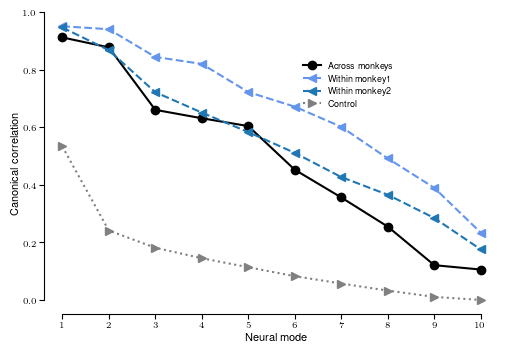

In [10]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    plot_cca_for_ex(ax)
    

---

monkey population CCA plot

In [92]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [6]:
@utility.report
def plot_monkey_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData1_ = dt.get_data_array(side2df, monkey_defs.fixation_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,0))

Executed: `plot_monkey_cca` in 6.6s


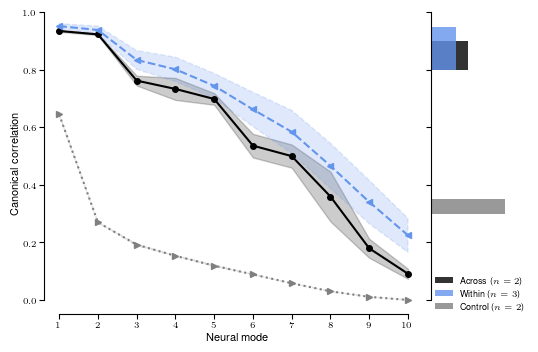

In [7]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

decoding for monkeys

In [54]:
@utility.report
def plot_monkey_decoding(ax, full_list, allDFs):
    defs = monkey_defs
    pairIndexList = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndexList.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 != animal2: continue
            if session1 == session2: continue
            pairIndexList[-1][1].append(j)

    reg_scores = []
    for i, df in enumerate(allDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        n_trials = int(AllData.shape[-3] /2)
        AllData1 = AllData[0,...][:,:n_trials, :,:]
        AllData2 = AllData[0,...][:,-n_trials:,:,:]
        AllVel1 = AllVel[0,...][:,:n_trials, :,:]
        AllVel2 = AllVel[0,...][:,-n_trials:,:,:]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        # controlling the size
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        Y_train_x,Y_train_y = AllVel1.T
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T

        x_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=5).mean()
        y_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=5).mean()

        reg_scores.append((i,(x_score,y_score)))
    pop_score_day = []
    for _,scores in reg_scores:
        pop_score_day.append(np.mean(scores))
    pop_score_day = np.array(pop_score_day)

    #=================================
    pairIndex_across = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_across.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if j <= i: continue
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        # train the decoder
        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_train_x,Y_train_y = AllVel1.T

        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        reg_scores_across.append((id1,testId,(x_score,y_score)))
    pop_score_across = []
    for _,_,scores in reg_scores_across:
        pop_score_across.append(np.mean(scores))
    pop_score_across = np.array(pop_score_across)

    #=======================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        Y_train_x,Y_train_y = AllVel1.T

        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(X1, Y_train_x)
        reg_y.fit(X1, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
        reg_latent_scores.append((id1,testId,(x_score,y_score)))
    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)

    #=====================================
    pairIndex_uni = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_uni.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairIndex_uni[-1][1].append(j)
    reg_scores_across = []
    for id1, testList in pairIndex_uni:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        X_ = AllData1.reshape((-1,AllData1.shape[-1]))
        AllVel1 = AllVel1.reshape((-1,2))
        Y_train_x,Y_train_y = AllVel1.T
        decode_x, decode_y = LinearRegression(), LinearRegression()
        decode_x.fit(X_, Y_train_x)
        decode_y.fit(X_, Y_train_y)
        for testId in testList:
            AllData, AllVel = defs.get_data_array_and_vel([allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

            AllData2 = AllData[0,...]
            AllVel2 = AllVel[0,...]
            # size matching
            *_,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
            X1 = AllData1[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
            X2 = AllData2[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
            AllVel2 = AllVel2[:,:n_trial,:n_time,:].reshape((-1,2))

            # alignment the decoder
            A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
            X2_aligned = X2 @ B @ linalg.inv(A) 

            # test the decoder
            Y_test_x,Y_test_y = AllVel2.T
            x_score = defs.custom_r2_func(Y_test_x, decode_x.predict(X2_aligned))
            y_score = defs.custom_r2_func(Y_test_y, decode_y.predict(X2_aligned))
            reg_scores_across.append((id1,testId,(x_score,y_score)))
    pop_score_uni = []
    for _,_,scores in reg_scores_across:
        pop_score_uni.append(np.mean(scores))
    pop_score_uni = np.array(pop_score_uni)


#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label=r'Across (\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across (\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)
    ax.hist(pop_score_uni, bins=bins, density=True, label='Universal',
            alpha=.8, color=params.colors.UniversalDecoder)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(0,.6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

Running: `plot_monkey_decoding` for 251.8s


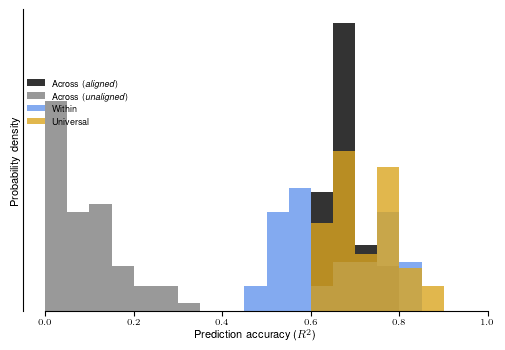

In [55]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_decoding(ax, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

Mouse CCA plot

In [17]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        print(fname)
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [3]:
@utility.report
def plot_mouse_cca(ax, ax_hist, allDFs_M1):
    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,0))

/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat
Executed: `get_full_mouse_data` in 0.9s
Executed: `plot_mouse_cca` in 10.0s


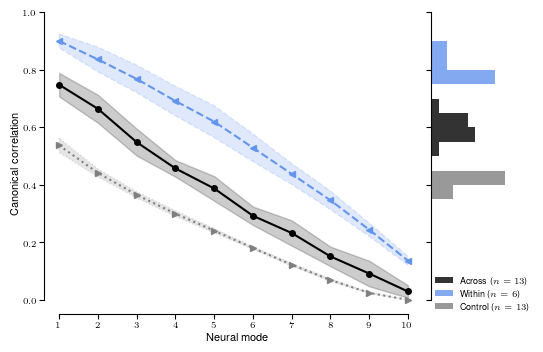

In [19]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax,ax_, allDFs_M1)
    
    plt.show()

---

plot the behavioural vs CCA

In [ ]:
@utility.report
def plot_monkey_cca_corr():
    

In [ ]:
if "__file__" not in dir():


# Part 2
Plot figure

Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_fr_raster` in 0.2s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_monkey_pc_example` in 0.3s
Executed: `plot_cca_for_ex` in 4.9s
Executed: `get_full_monkey_data` in 14.9s
Executed: `plot_monkey_cca` in 10.0s
Executed: `plot_monkey_decoding` in 15.7s
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat
/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat
Executed: `get_full_mouse_data` in 1.2s
Executed: `plot_mouse_cca` in 14.5s


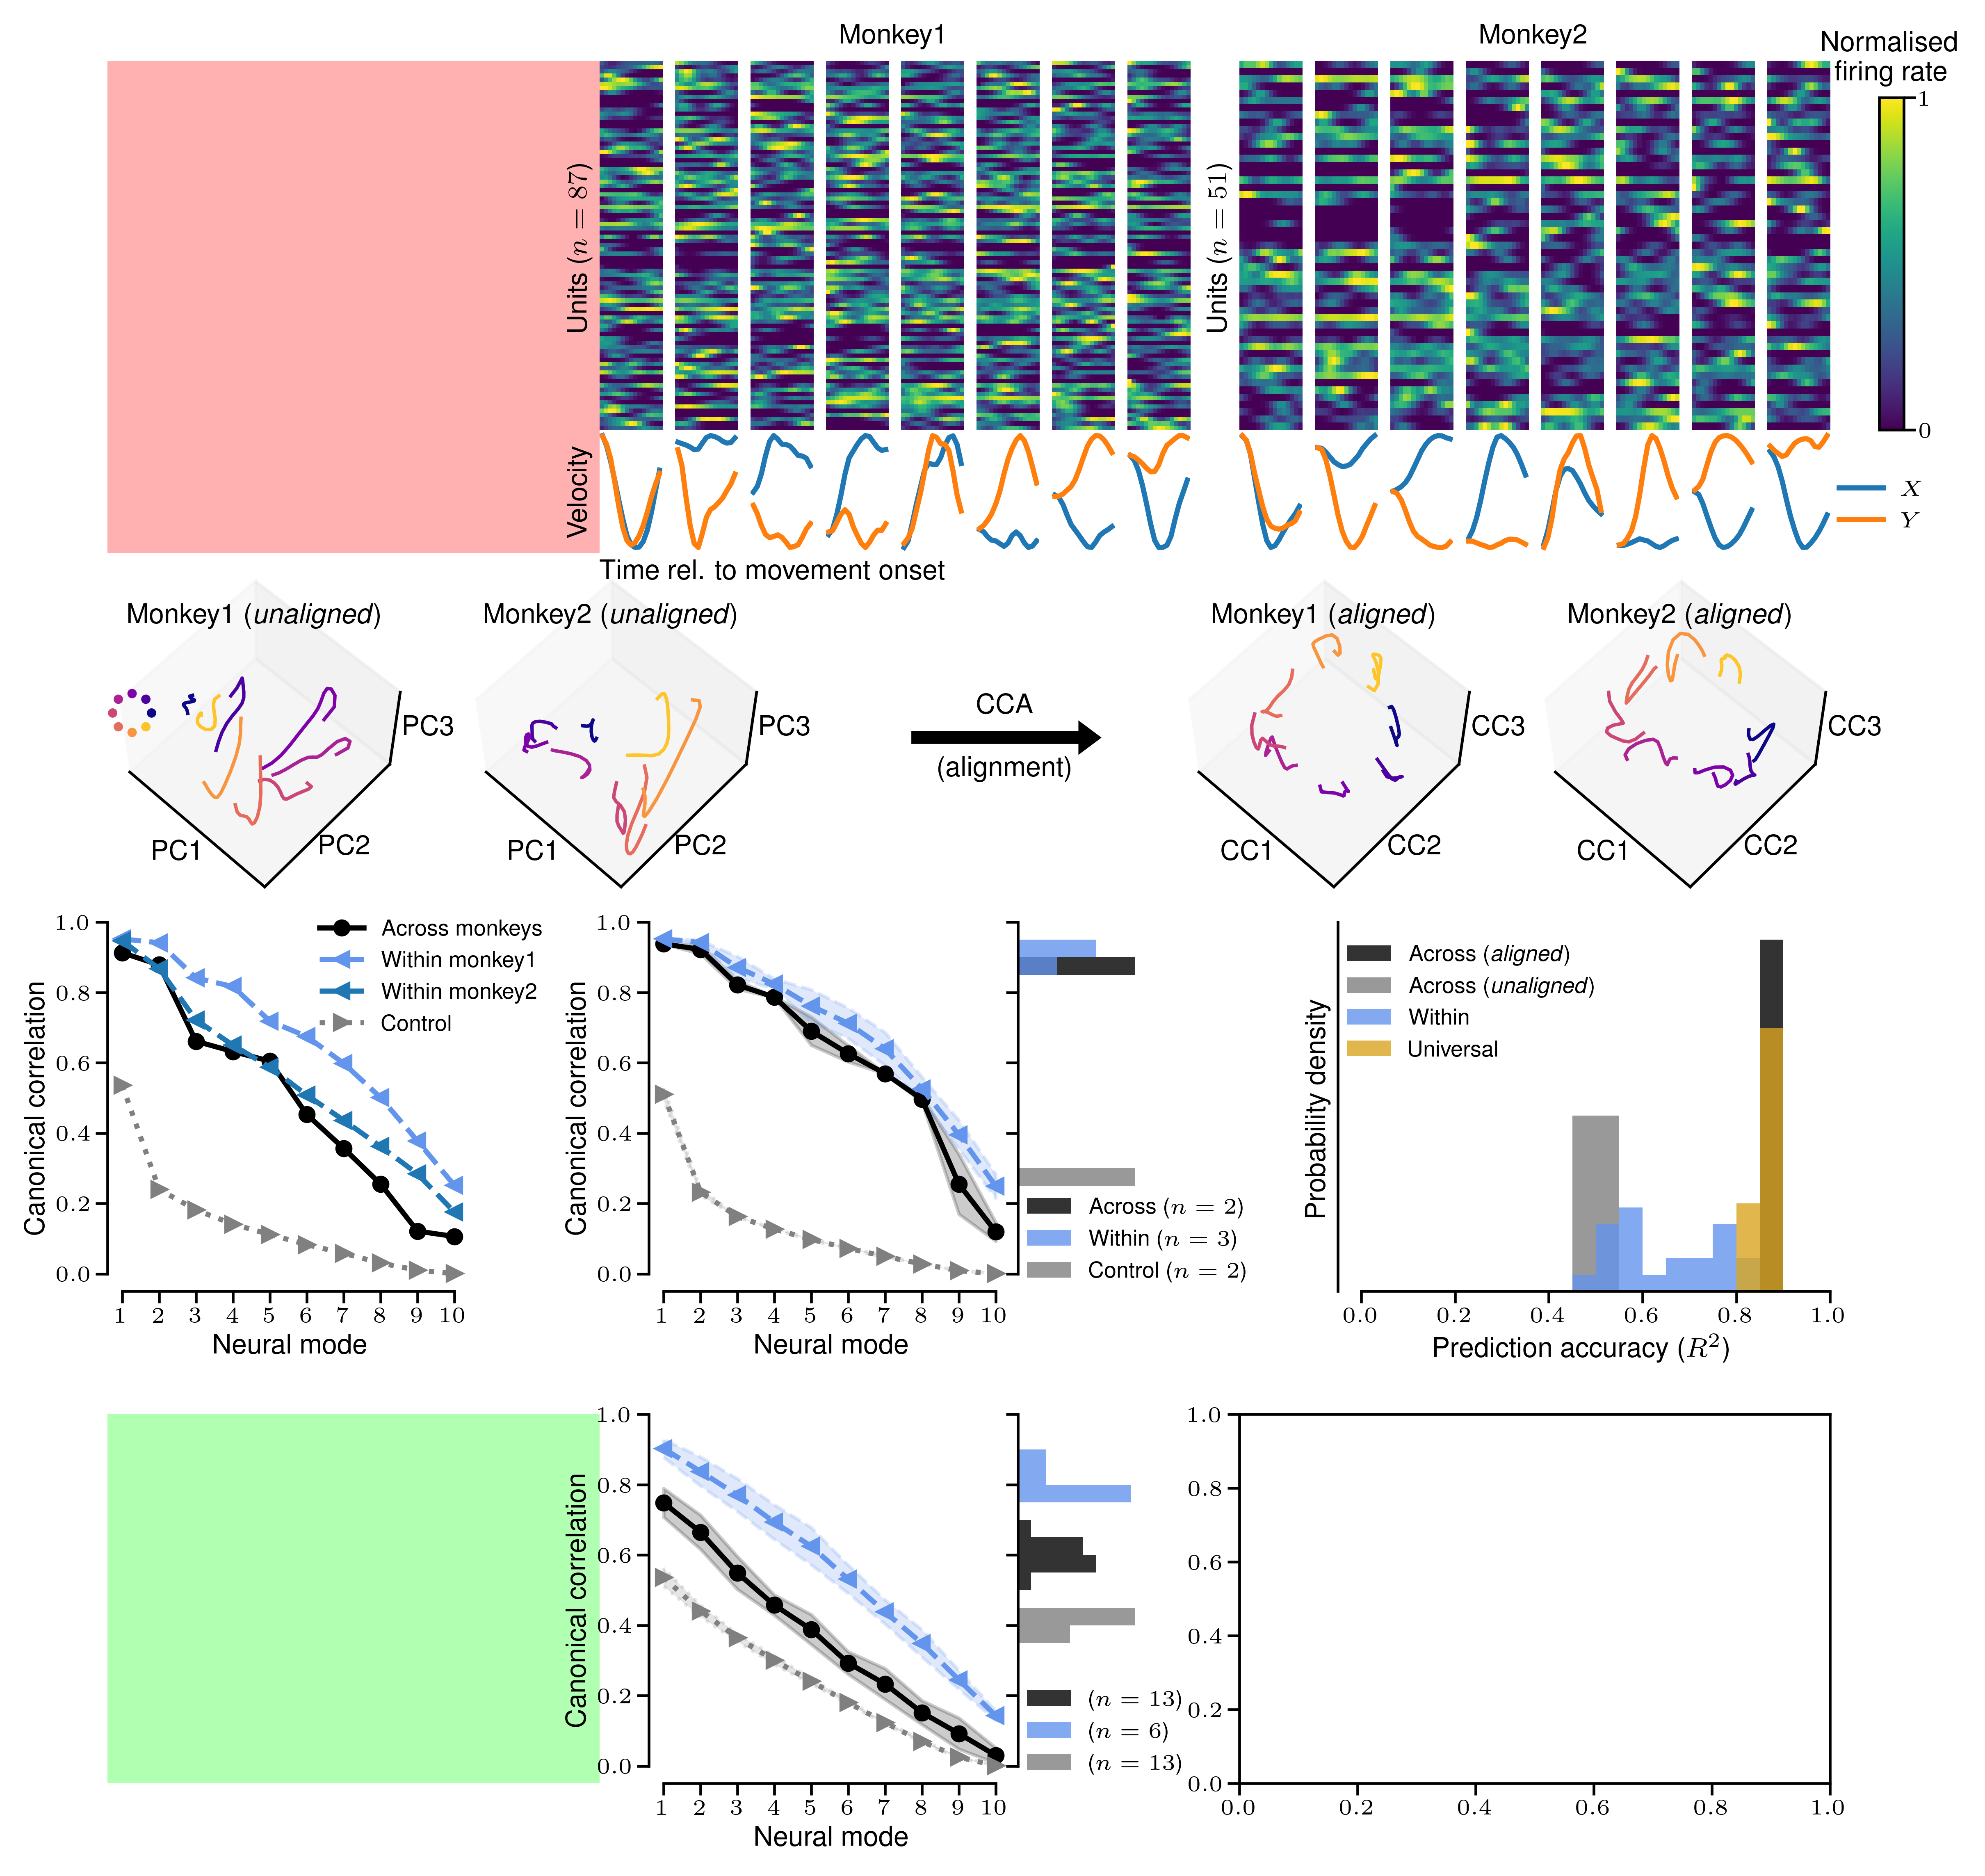

In [7]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([1,0,0,.3])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    
    gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])
    gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1]-params.panels.raster[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey1')
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey2')
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Velocity')
    axes2_3[0].set_xlabel('Time rel. to movement onset',loc='left')
    axes2_4[-1].legend(frameon=False, loc=(1.0,.1))
    
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1], 
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    
    axes3 = plot_monkey_pc_example(raster_example_df, gs3)
    
    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

    
    ##########################################
    # 4: CCA plot for the example animals
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    left=0,
                                    bottom=gs3.bottom*figsize[1]-params.panels.cca[1], 
                                    width=params.panels.cca[0],
                                    height=params.panels.cca[1])

    ax4 = fig.add_subplot(gs4[0])
    
    plot_cca_for_ex(ax4)
    

    
    
    ##########################################
    # 5: CCA plot for population
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs4.right+(.7/figsize[0]),  # .7" offset
                           right=gs4.right+ (.7/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax5,ax5_, full_list_MCx[10:13], allDFs_MCx)
    
    
    
    ##########################################
    # 6: Decoding for monkeys
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])

       
    plot_monkey_decoding(ax6, full_list_MCx[10:13], allDFs_MCx)

    
    
    ##########################################
    # 7: schematics Mouse
    gs7   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs6.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca[1])
    ax7   =fig.add_subplot(gs7[0])
    ax7 = utility.phantom_axes(ax7)
    ax7.set_facecolor([0,1,0,.3])

    
    
    
    ##########################################
    # 8: CCA plot for MICE
    gs8 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs5.left,
                           right=gs5.right,
                           bottom=gs7.bottom,
                           top=gs7.top,
                           wspace=0)

    ax8 = fig.add_subplot(gs8[0])
    ax8_ = fig.add_subplot(gs8[1])
    
    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax8,ax8_, allDFs_M1)
    
    
    
    ##########################################
    # 9: Behaviour vs CCA
    gs9   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs7.top*figsize[1],
                                    right=figsize[0],
                                    width=2.4,
                                    height=params.panels.decoding_hist[1])

    ax9 = fig.add_subplot(gs9[0])


    ##########################################

    # fig.savefig(params.figPath / 'figure2.pdf', format='pdf', bbox_inches='tight')